In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import re
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
from collections import Counter
from sklearn import metrics
from glob import glob as g
import missingno as msno

%matplotlib inline

In [5]:
filepath = '/Users/m/Desktop/MSCA Capstone/Chat-Disentangle-main/cleaned/'
agg_train = pd.read_csv((filepath + 'agg_train.csv'), header = 0)
agg_test = pd.read_csv((filepath + 'agg_test.csv'), header = 0)
agg_dev = pd.read_csv((filepath + 'agg_dev.csv'), header = 0)

In [6]:
agg_train.head(3)

,Unnamed: 0,raw,timestamp,user,message,file_ind,date,uuid,parent,child,file_ind_parent,uuid_parent
0,0,[09:14] <crimsun> kleedrac: I'm afraid not. An...,09:14,crimsun,kleedrac: I'm afraid not. Any version of mpla...,0,2004-12-25,2004_12_25_09_14_crimsun_0,NaN,NaN,NaN,NaN
1,1,[09:14] <intinig> does a subversion gnome clie...,09:14,intinig,does a subversion gnome client exist?,1,2004-12-25,2004_12_25_09_14_intinig_1,NaN,NaN,NaN,NaN
2,2,[09:14] <kleedrac> crimsun: Hmmm ... I wonder ...,09:14,kleedrac,crimsun: Hmmm ... I wonder why it does that?,2,2004-12-25,2004_12_25_09_14_kleedrac_2,NaN,NaN,NaN,NaN


In [7]:
print(agg_train.shape[0] + agg_test.shape[0] + agg_dev.shape[0])

251891


In [8]:
comb = agg_train.append(agg_test, ignore_index = True)
comb = comb.append(agg_dev, ignore_index = True)
comb.shape[0]

/var/folders/sy/crpzkcg53m70gbpm7bsfwp700000gn/T/ipykernel_74556/1393475011.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/var/folders/sy/crpzkcg53m70gbpm7bsfwp700000gn/T/ipykernel_74556/1393475011.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


251891

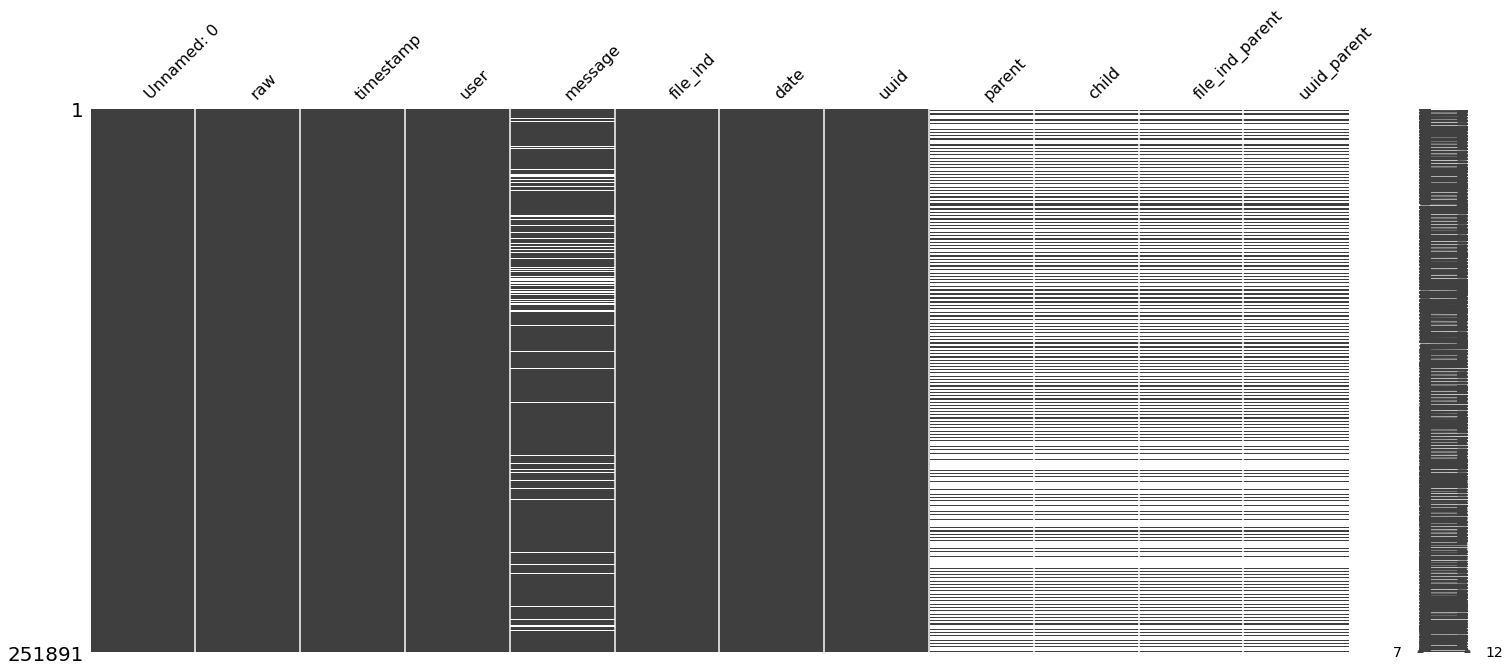

In [9]:
msno.matrix(comb)
plt.show()

In [10]:
comb["message"].isnull().sum()

27007

In [11]:
# Drop NaNs in message
comb = comb.dropna(subset=['message'])
comb["message"].isnull().sum()

0

## Messages

In [12]:
# Total messages
comb['message'].describe()

count     224884
unique    201464
top           ok
freq         766
Name: message, dtype: object

In [47]:
# Average message character length
comb['message'].apply(len).mean()

59.01040981128048

In [50]:
# Average message word length
comb['message'].str.split().apply(len).mean()

10.177264723146155

<AxesSubplot: >

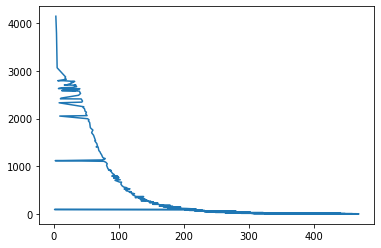

In [69]:
comb['message'].apply(len).value_counts().plot(kind = 'line')


## Users

In [14]:
# Unique users
len(comb["user"].unique())

17751

In [15]:
# Count how many messages each user has sent
user_counts = pd.DataFrame(comb["user"].value_counts())
user_counts.reset_index(inplace = True)
user_counts.columns = ['user', 'messages']
user_counts.head(10)

,user,messages
0,ubottu,3322
1,ActionParsnip,2108
2,ubotu,1913
3,Dr_Willis,1794
4,ikonia,1792
5,Seveas,1608
6,bazhang,1029
7,Psil0Cybin,905
8,bob2,868
9,cfhowlett,842


Text(0, 0.5, 'Count')

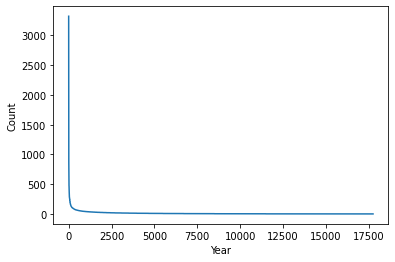

In [43]:
# Message count distribution per user
user_counts.messages.plot(kind = 'line')
plt.xlabel("Year")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

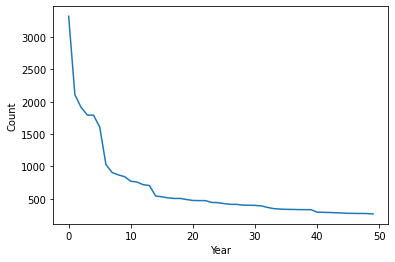

In [44]:
# Message count distribution per user, only top 50
user_counts.messages.head(50).plot(kind = 'line')
plt.xlabel("Year")
plt.ylabel("Count")

## Time analysis

In [17]:
# Cleanup timestamps
comb_nosys = comb[comb['timestamp'] != "System"]
dates = comb_nosys['date'] + ' ' + comb_nosys['timestamp']
dates = pd.to_datetime(dates)
dates.value_counts()

2006-12-20 05:12:00    72
2006-06-05 12:59:00    45
2005-12-16 06:49:00    43
2006-06-01 12:22:00    40
2006-05-27 00:21:00    38
                       ..
2018-02-27 02:42:00     1
2018-02-27 02:41:00     1
2015-06-12 12:53:00     1
2018-02-27 02:36:00     1
2016-12-19 21:59:00     1
Length: 43587, dtype: int64

In [18]:
# Start and end
dates.min(), dates.max()

(Timestamp('2004-11-15 01:00:00'), Timestamp('2018-02-27 23:46:00'))

In [19]:
# Span of time
dates.max() - dates.min()

Timedelta('4852 days 22:46:00')

Text(0, 0.5, 'Count')

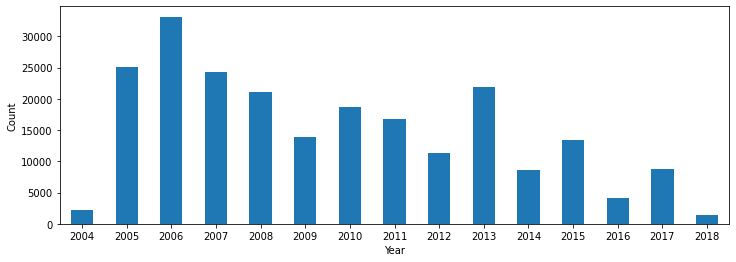

In [20]:
# Activity by year
fig, axs = plt.subplots(figsize=(12, 4))
dates.groupby(dates.dt.year).count().plot(kind = 'bar', rot=0)
plt.xlabel("Year")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

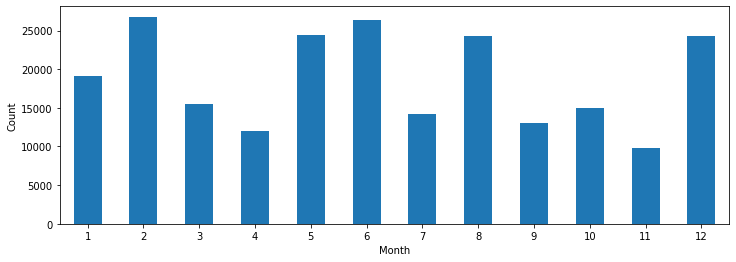

In [21]:
# Average activity by month
fig, axs = plt.subplots(figsize=(12, 4))
dates.groupby(dates.dt.month).count().plot(kind = 'bar', rot=0)
plt.xlabel("Month")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

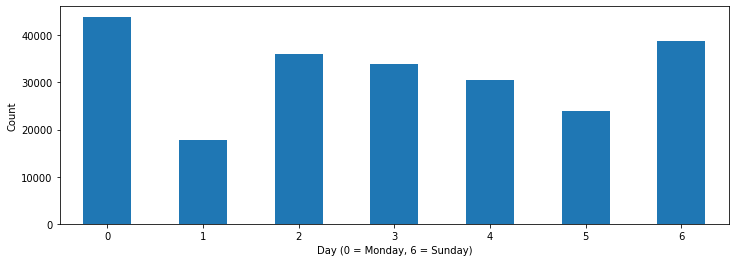

In [22]:
# Average activity by weekday
fig, axs = plt.subplots(figsize=(12, 4))
dates.groupby(dates.dt.weekday).count().plot(kind = 'bar', rot=0)
plt.xlabel("Day (0 = Monday, 6 = Sunday)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

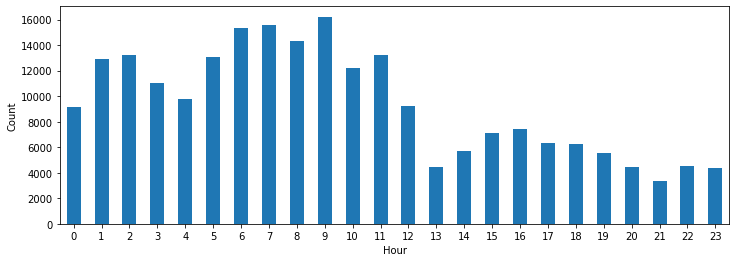

In [23]:
# Average activity by hour
fig, axs = plt.subplots(figsize=(12, 4))
dates.groupby(dates.dt.hour).count().plot(kind = 'bar', rot=0)
plt.xlabel("Hour")
plt.ylabel("Count")

## NLTK Vectorization

In [24]:
# Vectorize text

# Define stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

# Create a function that will perform cleanup and tokenization.
def cleanup(a):
    # Tokenize words
    words = nltk.tokenize.word_tokenize(a)
    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
    # Remove punctuation
    words = [word for word in words if word.isalpha()]
    # Lowercase all words (default_stopwords are lowercase too)
    words_lc = [word.lower() for word in words]
    # Remove stopwords
    words_lc = [word for word in words_lc if word not in stopwords]
    return words_lc

# Applying the code cleaner function to all rows to have just comments
message_clean = comb["message"].apply(cleanup)

message_clean.head(3)

0    [kleedrac, afraid, version, mplayer, except, w...
1                   [subversion, gnome, client, exist]
2                              [crimsun, hmmm, wonder]
Name: message, dtype: object

## NER with SpaCy

In [25]:
# Flatten message column into string
flat_text = ' '.join(map(str, message_clean))
flat_text[0:200]

"['kleedrac', 'afraid', 'version', 'mplayer', 'except', 'work', 'cpu'] ['subversion', 'gnome', 'client', 'exist'] ['crimsun', 'hmmm', 'wonder'] ['best', 'media', 'player', 'vlc', 'wxvlc', 'plays', 'eve"

In [26]:
len(flat_text)

11163846

In [27]:
# Set up SpaCy
nlp_text = nlp(flat_text[0:1000000])

# Create variables to populate with labels
entities = []
labels = []

# Populate and display table
for ent in nlp_text.ents:
    entities.append(ent)
    labels.append(ent.label_)
    
df = pd.DataFrame({'Entities':entities,'Labels':labels})

df.head(5)

,Entities,Labels
0,"(', years, ')",DATE
1,(first),ORDINAL
2,"(', yesterday, ')",DATE
3,(two),CARDINAL
4,"(', yesterday, ')",DATE


In [28]:
# Isolate organization entities
orgs_tup = df[df.Labels == 'ORG'].Entities
orgs_tup.head()

38        (ibm)
68    (toshiba)
75        (sec)
82        (sec)
88        (sec)
Name: Entities, dtype: object

In [29]:
# Create flattening function to create strings from tuples
def stringer(a):
    return ' '.join(map(str, a))

# Stringing the tokens
orgs = orgs_tup.apply(stringer)
orgs.head()

38        ibm
68    toshiba
75        sec
82        sec
88        sec
Name: Entities, dtype: object

In [30]:
# Create counts and sort by counts
counts = Counter(orgs)
counts.most_common(30)

[('sec', 21),
 ('fujitsu', 17),
 ('ibm', 10),
 ('gpg', 8),
 ('toshiba', 7),
 ('ford', 2),
 ('xerox', 2),
 ('kgb', 1),
 ('lotus', 1),
 ('cnn', 1),
 ('xdi', 1),
 ('ps', 1),
 ('doc', 1),
 ('cia', 1),
 ('toyota', 1)]